In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
from iexfinance.stocks import get_historical_data
from iexfinance.refdata import get_symbols
import iexfinance as iex

In [4]:
symbols=pd.DataFrame(get_symbols())
symbols.head()

,symbol,exchange,name,date,type,iexId,region,currency,isEnabled
0,A,NYS,Agilent Technologies Inc.,2020-02-03,cs,IEX_46574843354B2D52,US,USD,True
1,AA,NYS,Alcoa Corp.,2020-02-03,cs,IEX_4238333734532D52,US,USD,True
2,AAAU,PSE,Perth Mint Physical Gold ETF,2020-02-03,et,IEX_474B433136332D52,US,USD,True
3,AACG,NAS,ATA Creativity Global Sponsored ADR,2020-02-03,ad,IEX_44595A4C53392D52,US,USD,True
4,AADR,PSE,AdvisorShares Dorsey Wright ADR ETF,2020-02-03,et,IEX_5253355435362D52,US,USD,True


# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
list_of_tickers = ["SPY", "AGG"]

In [6]:
end_date = datetime.now()
start_date = end_date + timedelta(-365)
# YOUR CODE HERE
stock_df = get_historical_data(list_of_tickers, start_date, end_date, output_format='pandas')
stock_df.head()

SPY                                       AGG                  \
              open    high     low   close    volume    open    high     low   
date                                                                           
2019-02-04  270.11  272.03  269.36  271.96  60744844  106.83  106.90  106.77   
2019-02-05  272.44  273.44  271.88  273.10  79552774  106.95  107.14  106.95   
2019-02-06  272.79  273.34  271.92  272.74  58347791  107.20  107.22  106.99   
2019-02-07  270.94  271.55  268.29  270.14  95481961  107.15  107.20  107.03   
2019-02-08  268.75  270.58  267.83  270.47  75788861  107.17  107.38  107.17   

                              
             close    volume  
date                          
2019-02-04  106.88  14227726  
2019-02-05  107.11   8913510  
2019-02-06  107.05   6449575  
2019-02-07  107.10   3938913  
2019-02-08  107.34   4288562

In [7]:
stock_df_filtered = stock_df.drop(columns=['open','high','low','volume'], level=1)

In [8]:
stock_df_filtered.head()

,SPY,AGG
,close,close
date,,
2019-02-04,271.96,106.88
2019-02-05,273.10,107.11
2019-02-06,272.74,107.05
2019-02-07,270.14,107.10
2019-02-08,270.47,107.34


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [9]:
# Calculate the daily roi for the stocks
# YOUR CODE HERE
daily_returns = stock_df_filtered.pct_change()
daily_returns.head()

,SPY,AGG
,close,close
date,,
2019-02-04,NaN,NaN
2019-02-05,0.004192,0.002152
2019-02-06,-0.001318,-0.000560
2019-02-07,-0.009533,0.000467
2019-02-08,0.001222,0.002241


In [10]:
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_agg

0.0002806400647534125

In [11]:
# Calculate volatility
# YOUR CODE HERE
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_agg

0.002062937876309521

In [12]:
# Save the last day's closing price
# YOUR CODE HERE
last_day_spy = stock_df_filtered['SPY']['close'][-1]
last_day_agg = stock_df_filtered['AGG']['close'][-1]
last_day_spy


321.73

In [13]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_trading_days = 252 * 30
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [14]:
# Run the Monte Carlo Simulation
for n in range(number_simulations):
    simulated_spy_prices = [last_day_spy]
    simulated_agg_prices = [last_day_agg]
    
    for i in range(number_trading_days):
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)

    monte_carlo["SPY prices"] = pd.Series(simulated_spy_prices)
    monte_carlo["AGG prices"] = pd.Series(simulated_agg_prices)
    
    simulated_daily_returns = monte_carlo.pct_change()
    weights = [0.60,0.40]
    
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002643,0.996030,0.993719,0.999725,1.005333,1.006447,1.008810,0.996637,1.001723,0.999200,...,1.002026,0.995957,1.006837,1.000019,0.997820,1.002929,0.996459,0.994296,1.002902,0.997481
2,1.007347,0.999722,0.993097,0.998760,1.008412,0.997940,1.003602,0.986653,1.000982,1.007132,...,1.004043,1.002883,1.009783,1.001612,0.999181,0.999911,0.996022,0.994739,1.002835,1.001068
3,1.006628,0.999790,0.996439,0.993348,1.007814,1.000820,1.007303,0.981010,1.000806,1.014921,...,1.004111,1.005436,1.014213,1.003069,0.992987,0.998788,0.999591,1.000013,1.006053,1.000023
4,1.014929,1.002564,0.993138,0.998875,1.009297,0.996171,1.006207,0.978402,1.008279,1.005452,...,1.005908,1.003813,1.012906,1.007922,0.998832,0.995992,0.994313,1.000731,1.010353,1.003359


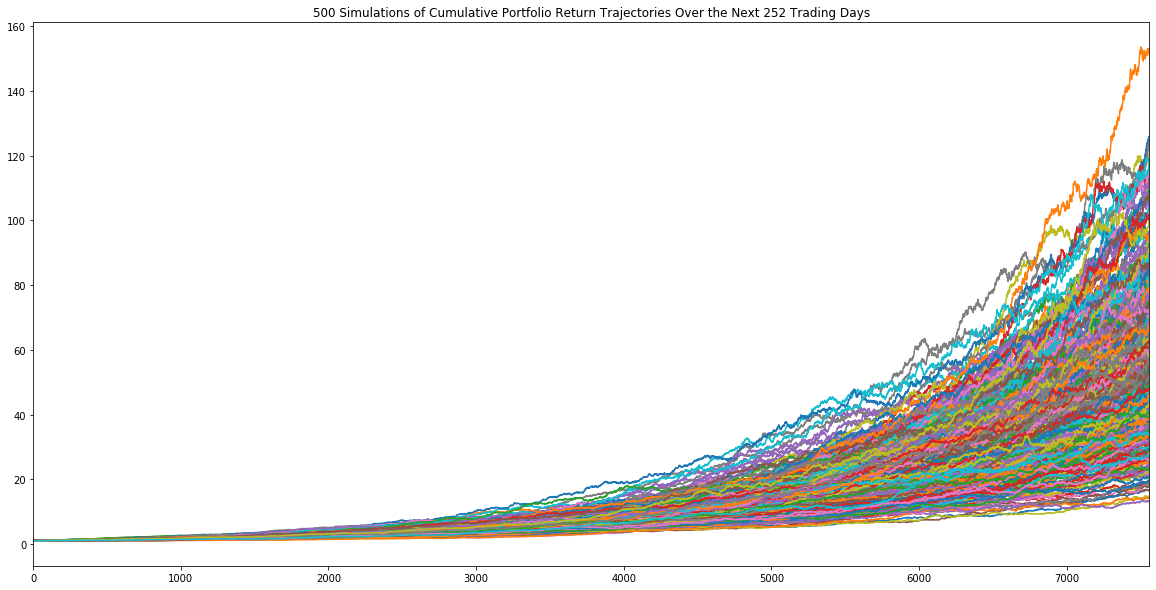

In [15]:
# Visualize the Simulation
# YOUR CODE HERE
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title, figsize=(20,10))

In [16]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
# YOUR CODE HERE
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    57.835593
1    48.121386
2    64.933156
3    68.029539
4    62.196268
Name: 7560, dtype: float64

In [17]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_trading_days_2 = 252 * 20
monte_carlo_2 = pd.DataFrame()
portfolio_cumulative_returns_2 = pd.DataFrame()

In [18]:
# Run the Monte Carlo Simulation
for n in range(number_simulations):
    simulated_spy_prices_2 = [last_day_spy]
    simulated_agg_prices_2 = [last_day_agg]
    
    for i in range(number_trading_days_2):
        simulated_spy_price_2 = simulated_spy_prices_2[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price_2 = simulated_agg_prices_2[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        
        simulated_spy_prices_2.append(simulated_spy_price_2)
        simulated_agg_prices_2.append(simulated_agg_price_2)

    monte_carlo_2["SPY prices"] = pd.Series(simulated_spy_prices_2)
    monte_carlo_2["AGG prices"] = pd.Series(simulated_agg_prices_2)
    
    simulated_daily_returns_2 = monte_carlo_2.pct_change()
    
    portfolio_daily_returns_2 = simulated_daily_returns_2.dot(weights)
    
    portfolio_cumulative_returns_2[n] = (1 + portfolio_daily_returns_2.fillna(0)).cumprod()

portfolio_cumulative_returns_2.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001344,0.990521,1.000922,0.996396,0.996247,1.008028,1.003695,0.994380,1.005950,0.999137,...,0.997735,1.004871,0.990782,1.000477,0.994325,0.998864,0.996472,0.997482,0.997155,0.991575
2,0.998625,0.995145,1.000017,0.994519,0.994339,1.009741,1.010949,0.990008,1.016667,0.996221,...,0.995324,1.000894,0.987692,1.001201,0.987692,1.000814,0.990811,0.996841,0.995597,0.988262
3,0.996848,0.997713,1.001687,0.993902,0.995428,1.001917,1.011106,0.997811,1.015594,0.999947,...,0.993608,0.998692,0.983792,1.001249,0.988769,1.012931,0.989404,0.990623,0.995961,0.994018
4,0.999330,0.996595,1.006600,0.999037,0.988533,1.004123,1.011144,1.000383,1.012531,1.000740,...,0.996210,1.003038,0.985192,1.004594,0.986570,1.008393,0.992426,0.995095,0.994759,1.005431


In [19]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# YOUR CODE HERE
ending_cumulative_returns_2 = portfolio_cumulative_returns_2.iloc[-1, :]
ending_cumulative_returns_2.head()

0    17.281934
1    10.381630
2    16.756901
3    26.635110
4    11.985482
Name: 5040, dtype: float64

In [20]:
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)

(40.661, 54.488]      0.334
(26.835, 40.661]      0.200
(54.488, 68.314]      0.198
(68.314, 82.141]      0.106
(12.869, 26.835]      0.068
(82.141, 95.967]      0.052
(109.793, 123.62]     0.018
(95.967, 109.793]     0.018
(123.62, 137.446]     0.004
(137.446, 151.273]    0.002
Name: 7560, dtype: float64

In [21]:
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    25.157840
0.95    94.255098
Name: 7560, dtype: float64

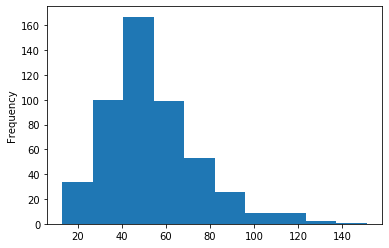

In [22]:
# Display the 90% confidence interval for the ending returns
# YOUR CODE HERE
ending_cumulative_returns.plot(kind='hist', bins=10)

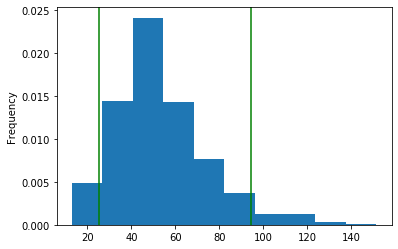

In [23]:
# Visualize the distribution of the ending returns
# YOUR CODE HERE
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='g')
plt.axvline(confidence_interval.iloc[1], color='g')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [29]:
# YOUR CODE HERE
confidence_interval_2 = ending_cumulative_returns.quantile(q=[0.50, 0.50])
confidence_interval_2

0.5    49.174206
0.5    49.174206
Name: 7560, dtype: float64

In [30]:
confidence_interval_3 = ending_cumulative_returns.quantile(q=[0.10, 0.90])
confidence_interval_3

0.1    30.971005
0.9    79.774074
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [32]:
# YOUR CODE HERE
initial_investment = 20000

tenth_percentile_investment_rtn = initial_investment * confidence_interval_3.iloc[0]
fiftieth_percentile_investment_rtn = initial_investment * confidence_interval_2.iloc[0]
ninetieth_percentile_investment_rtn = initial_investment * confidence_interval_3.iloc[1]

print(f'The expected returnes based on varying confidence intervales are as folows: 10th percentile return is ${tenth_percentile_investment_rtn}, 50th percentile return is ${fiftieth_percentile_investment_rtn} and the 90th percentile return would be ${ninetieth_percentile_investment_rtn}.' )


The expected returnes based on varying confidence intervales are as folows: 10th percentile return is $619420.0962866921, 50th percentile return is $983484.1142930966 and the 90th percentile return would be $1595481.4855827175.


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [33]:
# YOUR CODE HERE
withdraw_rate = tenth_percentile_investment_rtn * 0.04
withdraw_rate

24776.803851467685

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [38]:
# YOUR CODE HERE
new_investment = (initial_investment * 1.5)
tenth_per_inv_rtn = new_investment * confidence_interval_3.iloc[0]
fiftierth_per_inv_rtn = new_investment * confidence_interval_2.iloc[0]
ninetieth_per_inv_rtn = new_investment * confidence_interval_3.iloc[1]
print( f'${tenth_per_inv_rtn}\n ${fiftierth_per_inv_rtn}\n ${ninetieth_per_inv_rtn}')


$929130.1444300382
 $1475226.1714396449
 $2393222.228374076


In [28]:
# YOUR CODE HERE